In [1]:
import sys, serial, argparse, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
#import matplotlib.animation as animation
import scipy
from scipy import signal
from collections import deque

In [2]:
ser = serial.Serial(
    port='com3',
    baudrate=9600,
)

In [ ]:
del ser

# Real-time signal

### Initialization - Zero setting

#### sampling rate 변함 = 값이 커지거나 급변할 때 (터치, proximity sensing) 줄어듦 (9600 아닌 값들)
#### 9600 에서는 38, 39 유지함 => 38.5 Hz

In [3]:
sensor1, sensor2, sensor3, sensor4, index  = [], [], [], [], []

init_time = 5  #sec
window_size, Sampling_freq = 50, 38.5

init_period = Sampling_freq * init_time


def init(given_init_period):
    init_s1, init_s2, init_s3, init_s4 = [], [], [], []
    print("INIT 시작!!! ------------------------------------------------------------------------------ ")
    
    for i in range(int(init_period)):
        
        tmp = ser.readline()
        s1, s2, s3, s4, idx = tmp.decode()[:5], tmp.decode()[6:11], tmp.decode()[12:17], tmp.decode()[18:23], tmp.decode()[23:]
        
        if i == int(init_period) -1:
            end_period = float(idx) - 5000000
        
        try:
            s1, s2, s3, s4, idx = (int(s1)-10000), (int(s2)-10000), (int(s3)-10000), (int(s4)-10000), (float(idx)-5000000)
            
            if True:
                sensor1.append(s1)
                sensor2.append(s2)
                sensor3.append(s3)
                sensor4.append(s4)
                
                init_s1.append(s1)
                init_s2.append(s2)
                init_s3.append(s3)
                init_s4.append(s4)

                index.append(idx)
                
        except:
            pass

    return np.mean(init_s1), np.mean(init_s2), np.mean(init_s3), np.mean(init_s4), end_period


offset_s1, offset_s2, offset_s3, offset_s4, init_end_time = init(init_period)

INIT 시작!!! ------------------------------------------------------------------------------ 


In [4]:
len(sensor1), len(sensor2), len(sensor3), len(sensor4), len(index)

(192, 192, 192, 192, 192)

=> 이건 맨 처음 = 처음에는 offset 이 없으므로 설정해줄 필요 없음 => 이 때 init 해주고나서 
다음 5초~10초 까지는 맨 처음 계산한 offset 빼주면 되고 다음 10~15초 까지는 다음 offset 빼주면 됨

= 맨처음 init 과 다음부터  init 은 조금 씩 다름

## 5초 간격으로 zero setting 완료

### 이제 할것

1. 필터링 할 방법 선정 => 이것도 절대값 씌우기
2. Th 설정: 움직이지 않았을 때 그것보다 조금 커야 하고 detection 값 보다 작아야 함
3. zero setting 이랑 Th 같이 5초 마다 업데이트
4. Th 가 detect 되었을 때는 업데이트 하면 안됨

In [5]:
init_s1, init_s2, init_s3, init_s4 = [], [], [], []
init_lst = []

while True:
    if ser.readable():
        res = ser.readline()
        s1, s2, s3, s4, idx = res.decode()[:5], res.decode()[6:11], res.decode()[12:17], res.decode()[18:23], res.decode()[23:]
                        
        try:
            s1, s2, s3, s4, idx = (int(s1)-10000), (int(s2)-10000), (int(s3)-10000), (int(s4)-10000), (float(idx)-5000000)

        except:
            print(idx, " index has Error")
            pass
        
        if type(s1) == int and type(s2) == int and type(s3) == int and type(s4) == int and type(idx) == float: 
            index.append(idx)
            
            for i in range (1,5):
                globals()['init_s{}'.format(i)].append(globals()['s{}'.format(i)])
                globals()['sensor{}'.format(i)].append(globals()['s{}'.format(i)] - globals()['offset_s{}'.format(i)])

            if idx % init_period == 0:  #매번 5초 마다 init 실행
                init_lst.append(idx)
                for k in range (1,5):
                    globals()['offset_s{}'.format(k)] = np.mean(globals()['init_s{}'.format(k)])
                    
                print(idx, offset_s1, offset_s2, offset_s3, offset_s4)
                init_s1, init_s2, init_s3, init_s4 = [], [], [], []

385.0 9.072538860103627 17.134715025906736 12.953367875647668 19.632124352331605
770.0 6.911688311688311 16.26233766233766 13.148051948051949 15.358441558441559
1155.0 5.984415584415585 15.732467532467533 12.716883116883118 13.197402597402597
1540.0 6.0519480519480515 15.98961038961039 13.174025974025975 14.005194805194805
1925.0 5.288311688311689 14.997402597402598 12.838961038961038 13.63116883116883
2310.0 5.0987012987012985 15.787012987012988 12.620779220779221 13.963636363636363
2695.0 7.223376623376623 17.727272727272727 13.08051948051948 13.103896103896103
3080.0 5.1220779220779225 16.194805194805195 12.833766233766234 13.449350649350649
3465.0 7.8779220779220775 15.231168831168832 12.709090909090909 12.6
3850.0 6.65974025974026 15.17142857142857 12.846753246753247 14.781818181818181
4235.0 7.984415584415585 15.685714285714285 13.08051948051948 13.158441558441558
4620.0 6.12987012987013 15.971428571428572 12.862337662337662 15.371428571428572
5005.0 5.880519480519481 16.02337662

KeyboardInterrupt: 

In [6]:
len(sensor1), len(sensor2), len(sensor3), len(sensor4), len(index), init_lst

(28211,
 28211,
 28211,
 28211,
 28211,
 [385.0,
  770.0,
  1155.0,
  1540.0,
  1925.0,
  2310.0,
  2695.0,
  3080.0,
  3465.0,
  3850.0,
  4235.0,
  4620.0,
  5005.0,
  5390.0,
  5775.0,
  6160.0,
  6545.0,
  6930.0,
  7315.0,
  7700.0,
  8085.0,
  8470.0,
  8855.0,
  9240.0,
  9625.0,
  10010.0,
  10395.0,
  10780.0,
  11165.0,
  11550.0,
  11935.0,
  12320.0,
  12705.0,
  13090.0,
  13475.0,
  13860.0,
  14245.0,
  14630.0,
  15015.0,
  15400.0,
  15785.0,
  16170.0,
  16555.0,
  16940.0,
  17325.0,
  17710.0,
  18095.0,
  18480.0,
  18865.0,
  19250.0,
  19635.0,
  20020.0,
  20405.0,
  20790.0,
  21175.0,
  21560.0,
  21945.0,
  22330.0,
  22715.0,
  23100.0,
  23485.0,
  23870.0,
  24255.0,
  24640.0,
  25025.0,
  25410.0,
  25795.0,
  26180.0,
  26565.0,
  26950.0,
  27335.0,
  27720.0,
  28105.0])

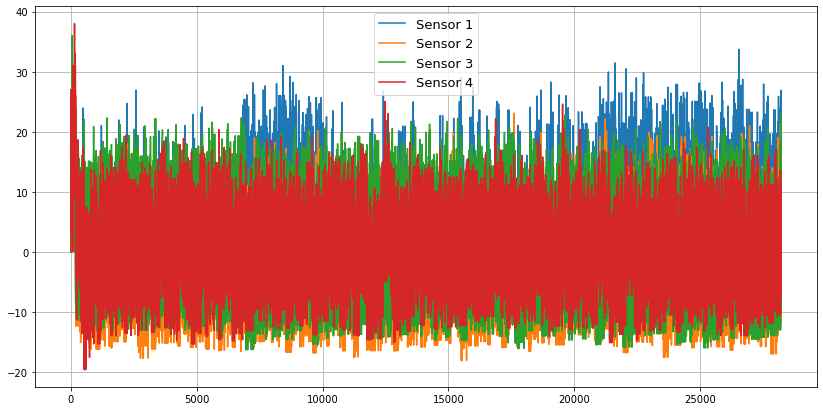

In [7]:
plt.figure(figsize=(14,7))
plt.plot(sensor1[1:], label='Sensor 1')
plt.plot(sensor2[1:], label='Sensor 2')
plt.plot(sensor3[1:], label='Sensor 3')
plt.plot(sensor4[1:], label='Sensor 4')
plt.legend(fontsize=13)

plt.grid(True)
plt.show()

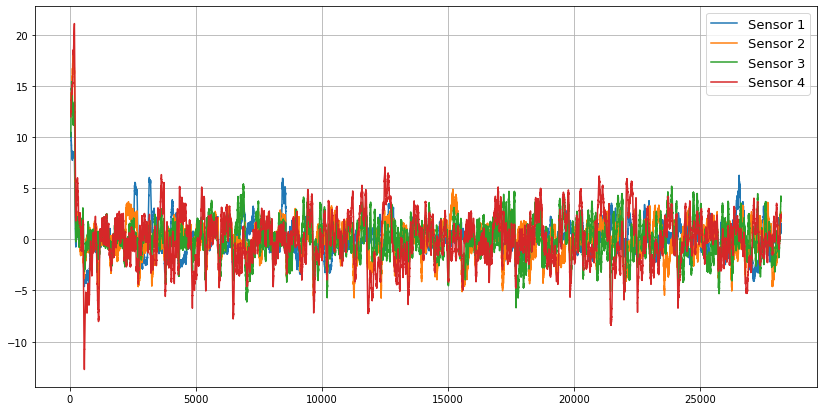

In [14]:
plt.figure(figsize=(14,7))

window_size = 50

series_s1, series_s2, series_s3, series_s4 = pd.Series(sensor1), pd.Series(sensor2), pd.Series(sensor3), pd.Series(sensor4)

s1_ma, s2_ma, s3_ma, s4_ma = series_s1.rolling(window=window_size).mean(), series_s2.rolling(window=window_size).mean(), series_s3.rolling(window=window_size).mean(), series_s4.rolling(window=window_size).mean()

plt.plot(s1_ma, label='Sensor 1')
plt.plot(s2_ma, label='Sensor 2')
plt.plot(s3_ma, label='Sensor 3')
plt.plot(s4_ma, label='Sensor 4')

#plt.ylim(-5,5)

plt.legend(fontsize=13)

plt.grid(True)
plt.show()

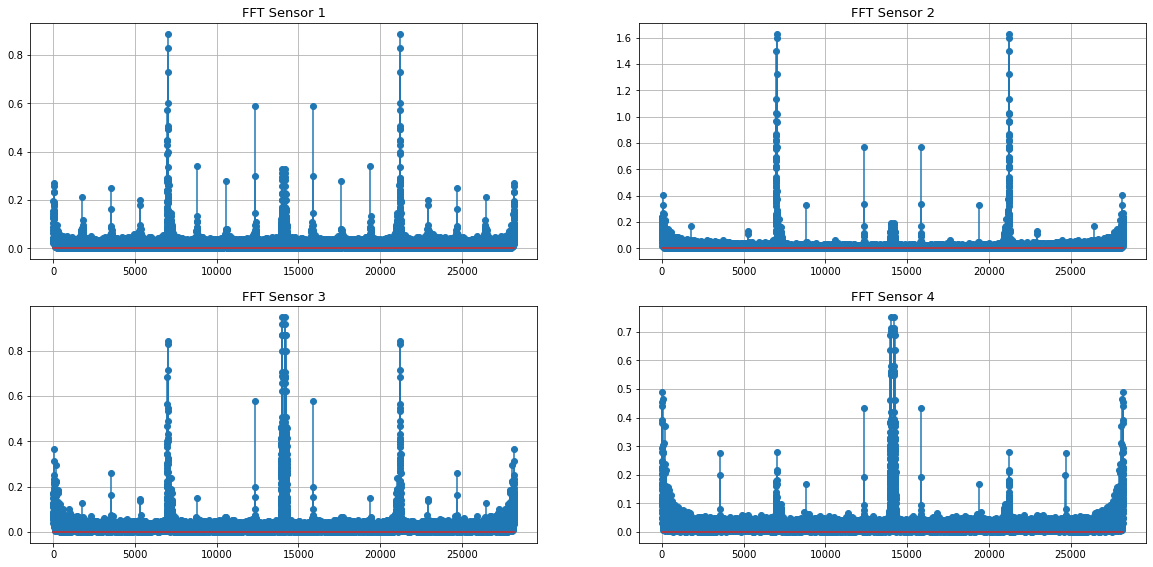

In [15]:
j=0
plt.figure(figsize=(20,20))

for i in range(1,5):
    plt.subplot(4, 2, i)
    fft = np.fft.fft(globals()['sensor{}'.format(i)]) / len(globals()['sensor{}'.format(i)])
    fft_magnitude = np.abs(fft)
    plt.title('FFT Sensor %d'%i, fontsize=13)
    plt.stem(fft_magnitude[1:])
    #plt.ylim(0,0.002)
    plt.grid(True)
    
#plt.tight_layout()
plt.show()

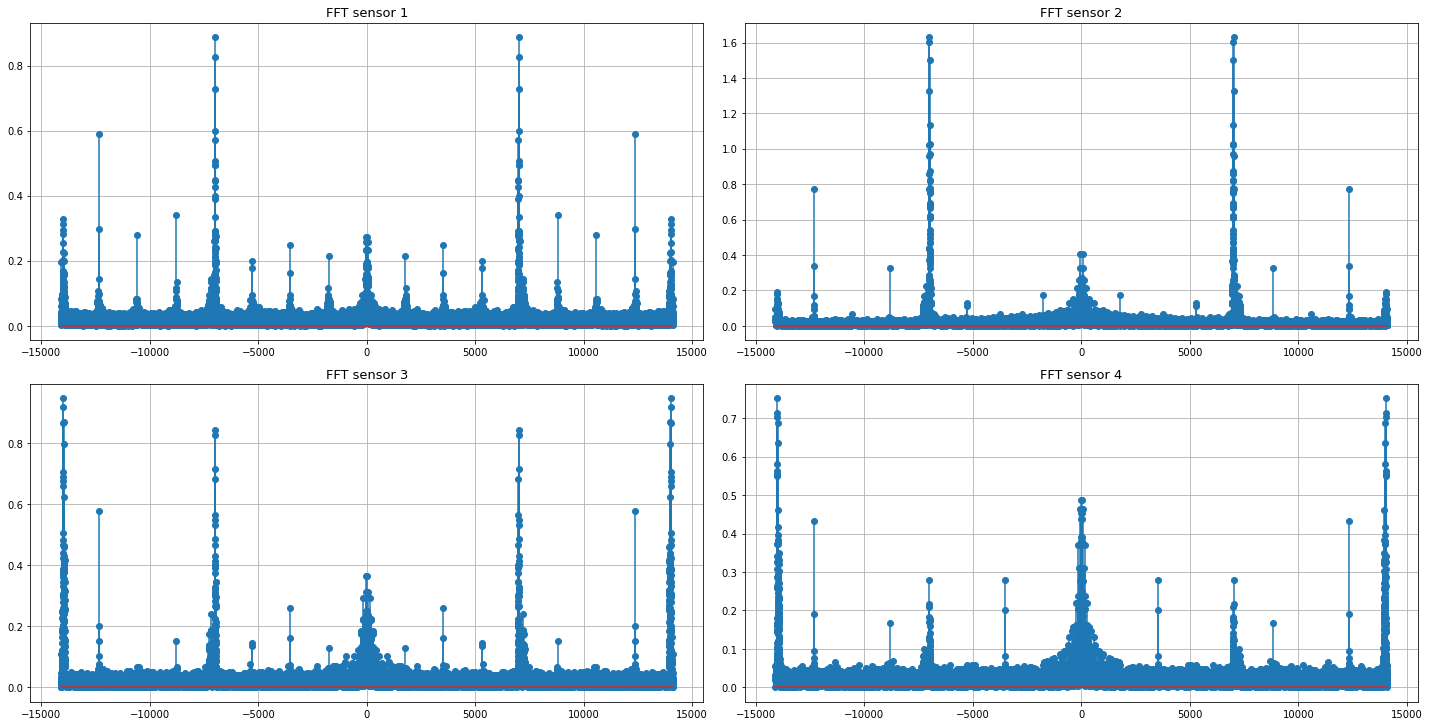

In [16]:
j=0
plt.figure(figsize=(20,20))

for i in range(1,5):
    j = j+1
    plt.subplot(4, 2, j)
    x = np.arange(-len(globals()['sensor{}'.format(i)])/2, len(globals()['sensor{}'.format(i)])/2)
    fft = np.fft.fft(globals()['sensor{}'.format(i)]) / len(globals()['sensor{}'.format(i)])
    fft_magnitude = np.abs(fft)
    fft_shift = np.fft.fftshift(fft_magnitude)    
    
    plt.title('FFT sensor %d'%i, fontsize=13)
    plt.stem(x, fft_shift)
    plt.grid(True)
    
plt.tight_layout()
plt.show()

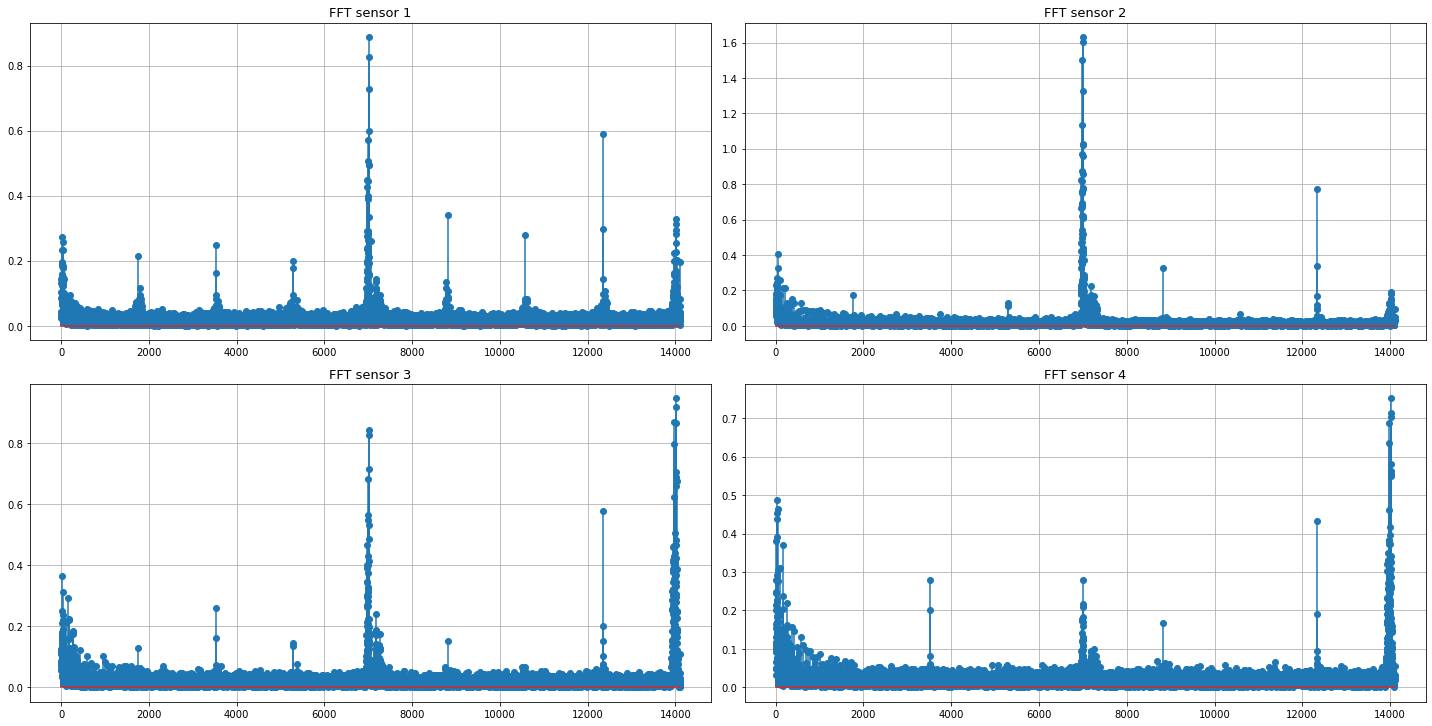

In [17]:
j=0
plt.figure(figsize=(20,20))

for i in range(1,5):
    plt.subplot(4, 2, i)
    x = np.arange(len(globals()['sensor{}'.format(i)])/2)
    fft = np.fft.fft(globals()['sensor{}'.format(i)]) / len(globals()['sensor{}'.format(i)])
    fft_magnitude = np.abs(fft)
    fft_shift = np.fft.fftshift(fft_magnitude)    
    
    plt.title('FFT sensor %d'%i, fontsize=13)
    plt.stem(x[1:], fft_shift[int(len(fft_shift)/2)+1:])
    plt.grid(True)
    
plt.tight_layout()
plt.show()

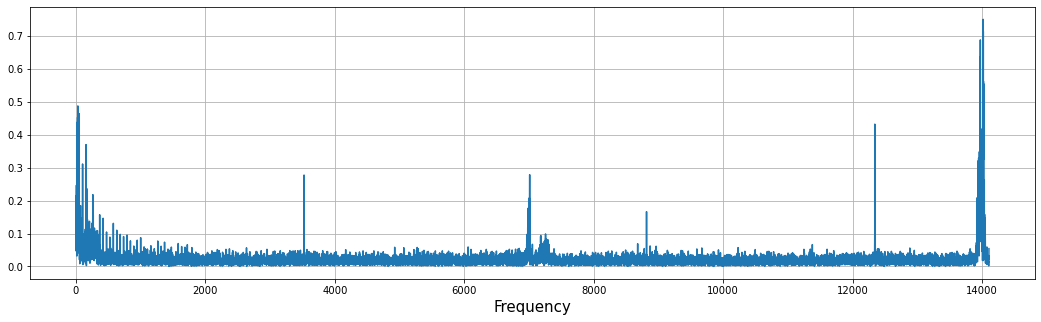

In [18]:
plt.figure(figsize=(18,5))
start_length = int(len(fft_shift)/2)+1
plt.plot(fft_shift[start_length:])
plt.xlabel('Frequency', fontsize=15)
plt.grid(True)

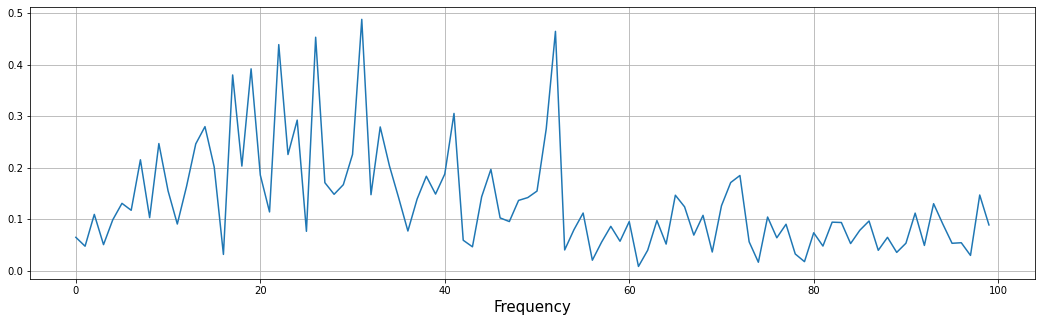

In [19]:
plt.figure(figsize=(18,5))
start_length = int(len(fft_shift)/2)+1
plt.plot(fft_shift[start_length:start_length+100])
plt.xlabel('Frequency', fontsize=15)
plt.grid(True)

# LPF

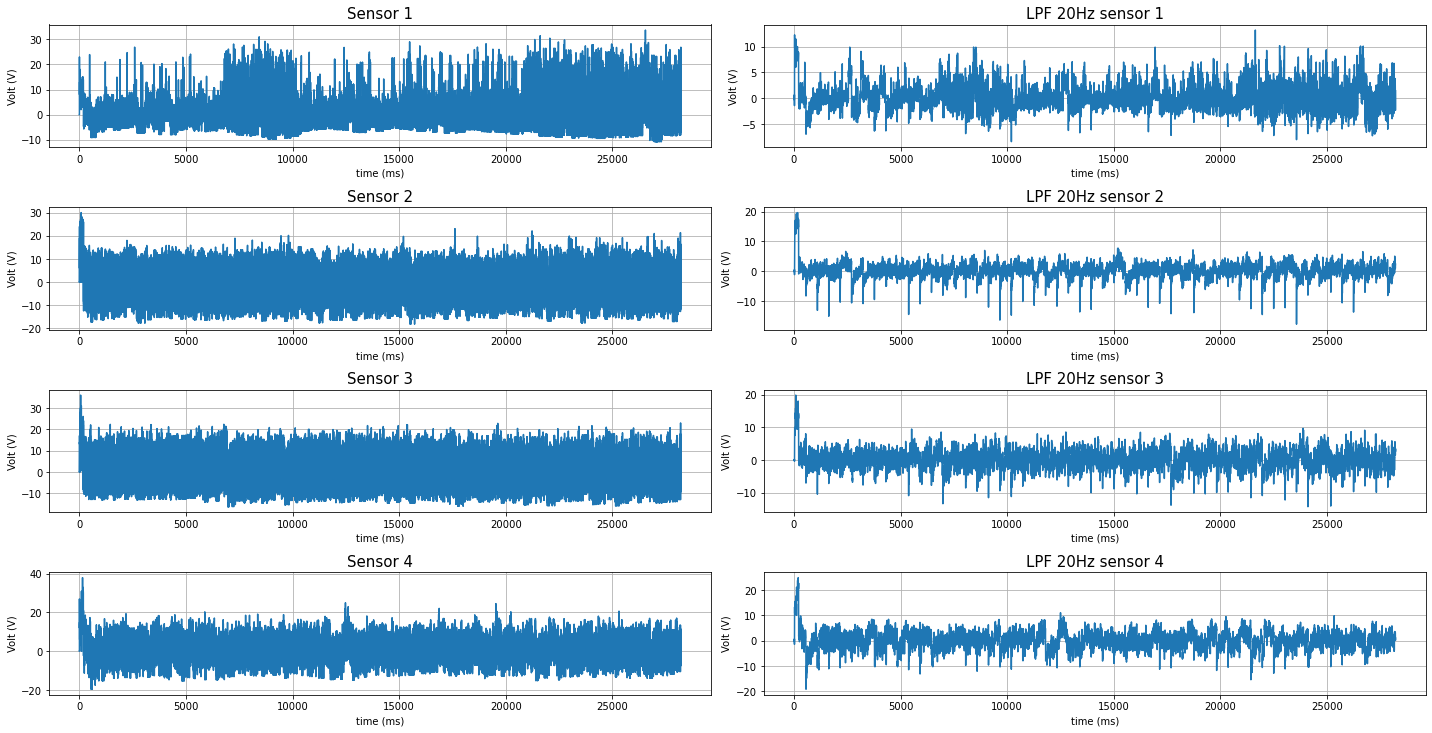

In [20]:
plt.figure(figsize=(20,20))
j,k=1,1

for i in range(1,9):
    plt.subplot(8, 2, i)
    
    if i%2 == 1:
        plt.plot(globals()['sensor{}'.format(j)])
        plt.title('Sensor %d'%j, fontsize=15)
        j = j+1
        
    if i%2 == 0:
        b = signal.firwin(window_size, cutoff=5, fs=Sampling_freq, pass_zero='lowpass')
        x1 = signal.lfilter(b, [1.0], globals()['sensor{}'.format(k)])

        plt.plot(x1)
        plt.title('LPF 20Hz sensor %d'%k, fontsize=15)
        k = k+1
        
    plt.xlabel('time (ms)')
    plt.ylabel('Volt (V)')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# 차분 신호 1: |t - (t-1)|

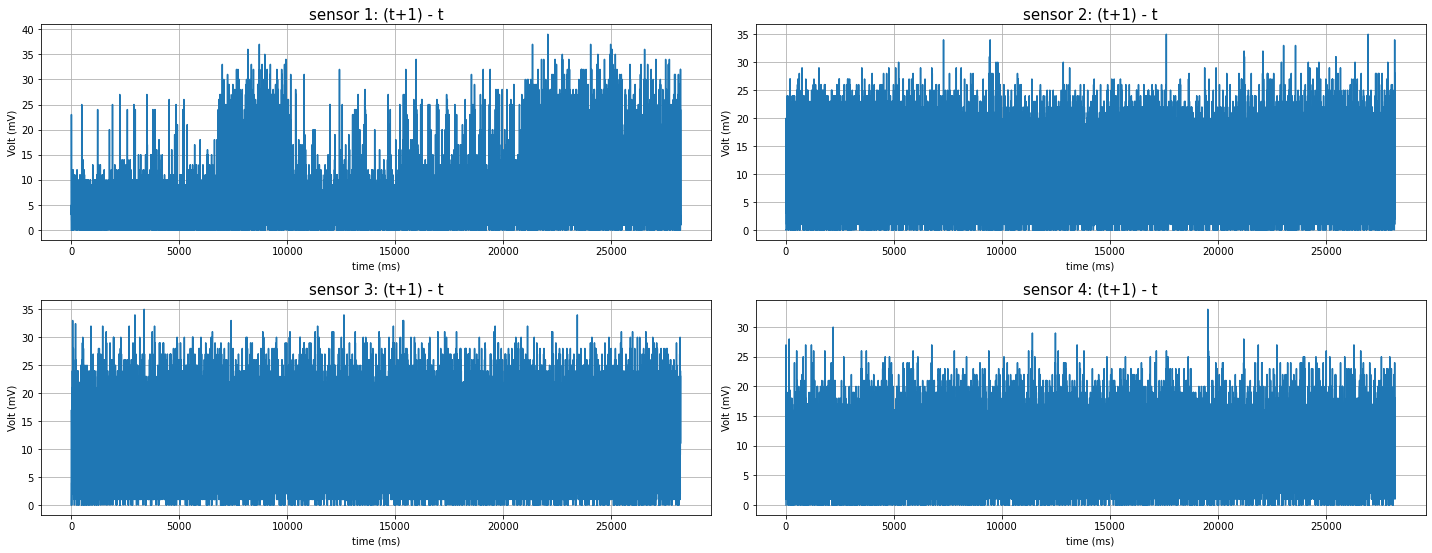

In [21]:
for j in range(1,5):
    globals()['t_subtracted{}'.format(j)] = []
    x1 = globals()['sensor{}'.format(j)]
    for i in range(len(globals()['sensor{}'.format(j)])-1):
        globals()['t_subtracted{}'.format(j)].append(np.abs(x1[i] - x1[i+1]))
        
plt.figure(figsize=(20,15))
j=0

for i in range(1,5):
    j = j+1
    plt.subplot(4, 2, j)
    plt.plot(globals()['t_subtracted{}'.format(i)])
    plt.title('sensor %d: (t+1) - t'%i, fontsize=15)
    plt.xlabel('time (ms)')
    plt.ylabel('Volt (mV)')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# 차분 신호 2

### Horizontal A-C, Vertical  B-D

#### 좋은 것 같지 않음

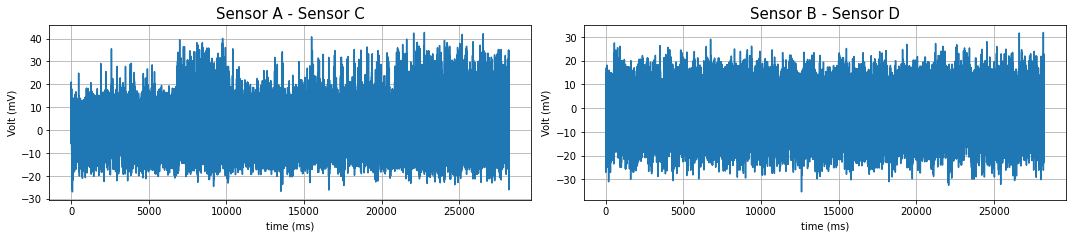

In [22]:
j=0
plt.figure(figsize=(15,6))

tmp = np.array(sensor1) - np.array(sensor3)
plt.subplot(2, 2, 1)
plt.plot(tmp)
plt.title('Sensor A - Sensor C', fontsize=15)
plt.grid(True)
plt.ylabel('Volt (mV)')
plt.xlabel('time (ms)')


tmp = np.array(sensor2) - np.array(sensor4)
plt.subplot(2, 2, 2)
plt.plot(tmp)
plt.title('Sensor B - Sensor D', fontsize=15)
plt.grid(True)
plt.ylabel('Volt (mV)')
plt.xlabel('time (ms)')

plt.tight_layout()
plt.show()

In [ ]:
손동작 했을 시 고유 신호  
1. FFt를 통해서 가장 잘나오는 대역 추출
2. 차분 신호
3. 차분 신호 2


=> 가장 잘되는 거 선정 후 
=>Zero setting
- Threshold 계산
- Dynamic Threshold => 정확도 평가
- Frame 추출
- 추출된 프레임 DL에 넣기

